In [ ]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.python.keras.layers import Input, Dense
from tensorflow.python.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.python.keras.models import Model


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **Création du générateur**

In [ ]:
base_sure_directory = '/content/drive/MyDrive/Base-sure'

In [ ]:
def extract_label_from_filename(filename):
    vote = filename.split('-')[1]
    label = int(vote.split('_')[0])
    return label

In [ ]:
class ImageLabelGenerator(object):
    def __init__(self, image_dir, batch_size=32, target_size=(224, 224), shuffle=True):
        self.image_dir = image_dir
        self.batch_size = batch_size
        self.target_size = target_size
        self.shuffle = shuffle
        self.image_filenames = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
        self.on_epoch_end()

    def __len__(self):
        # Retourne le nombre de lots par époque
        return int(np.floor(len(self.image_filenames) / self.batch_size))

    def __getitem__(self, index):
        # Génère un lot de données
        batch_filenames = self.image_filenames[index * self.batch_size:(index + 1) * self.batch_size]
        images = []
        labels = []

        for filename in batch_filenames:
            # Charger l'image
            img_path = os.path.join(self.image_dir, filename)
            image = tf.keras.utils.load_img(img_path, target_size=self.target_size)
            image = tf.keras.utils.img_to_array(image)
            #image = tf.keras.utils.img_to_array(image)
            #image = tf.keras.applications.mobilenet_v2.preprocess_input(image)

            # Extraire le label
            label = extract_label_from_filename(filename)

            images.append(image)
            labels.append(label)

        # Convertir en numpy arrays
        return np.array(images), np.array(labels)

    def on_epoch_end(self):
        if self.shuffle:
            # Mélanger les fichiers à la fin de chaque époque
            np.random.shuffle(self.image_filenames)

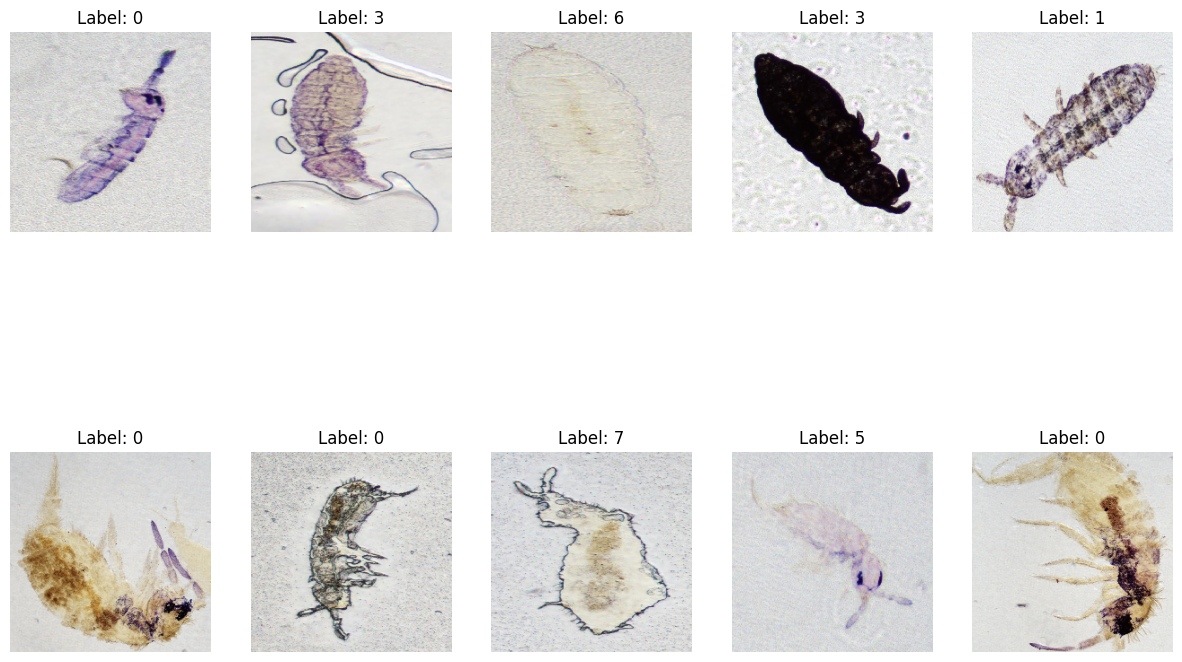

In [ ]:
# Instancier le générateur pour la base sûre
train_generator = ImageLabelGenerator(base_sure_directory, batch_size=32, target_size=(224, 224))

# Obtenir le premier lot du générateur
images, labels = train_generator[0]

# Afficher 10 images du dataset
plt.figure(figsize=(15, 10))
for i in range(10):
    plt.subplot(2, 5, i + 1)  # 2 lignes et 5 colonnes pour afficher 10 images
    plt.imshow(images[i].astype('uint8'))
    plt.title(f"Label: {labels[i]}")
    plt.axis('off')  # Désactive l'affichage des axes
plt.show()

### **MODELE RESNET AVEC SPLIT**


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import Sequence
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

# === 2. Générateur custom compatible ===
class ImageLabelGenerator(Sequence):
    def __init__(self, image_dir, image_filenames, batch_size=32, target_size=(224, 224), shuffle=True):
        self.image_dir = image_dir
        self.image_filenames = image_filenames
        self.batch_size = batch_size
        self.target_size = target_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.image_filenames) / self.batch_size))

    def __getitem__(self, index):
        batch_filenames = self.image_filenames[index * self.batch_size:(index + 1) * self.batch_size]
        images = []
        labels = []

        for filename in batch_filenames:
            try:
                label = int(filename.split('-')[1].split('_')[1])
            except:
                continue  # ignorer les fichiers mal formatés

            img_path = os.path.join(self.image_dir, filename)
            image = tf.keras.utils.load_img(img_path, target_size=self.target_size)
            image = tf.keras.utils.img_to_array(image)
            image = preprocess_input(image)

            images.append(image)
            labels.append(label)

        return np.array(images), np.array(labels)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.image_filenames)

# === 3. Préparer les fichiers et split train/val ===
base_sure_directory = '/content/drive/MyDrive/Base-sure'
all_images = [f for f in os.listdir(base_sure_directory) if f.endswith('.jpg')]

train_files, val_files = train_test_split(all_images, test_size=0.2, random_state=42, shuffle=True)

train_generator = ImageLabelGenerator(base_sure_directory, train_files, batch_size=32)
val_generator = ImageLabelGenerator(base_sure_directory, val_files, batch_size=32, shuffle=False)

# === 4. Créer le modèle ResNet50 ===
def create_resnet_model(input_shape=(224, 224, 3), num_classes=9):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # freeze le backbone
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    output = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=output)
    return model

model = create_resnet_model()

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# === 5. Callbacks ===
checkpoint_path = "/content/best_model_resnet.h5"
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True)
]

In [ ]:
# === 6. Entraînement ===
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - accuracy: 0.2267 - loss: 2.7251

28/28 ━━━━━━━━━━━━━━━━━━━━ 25s 548ms/step - accuracy: 0.2280 - loss: 2.7175 - val_accuracy: 0.3438 - val_loss: 2.0445
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - accuracy: 0.2737 - loss: 2.2752

28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 373ms/step - accuracy: 0.2742 - loss: 2.2731 - val_accuracy: 0.3527 - val_loss: 1.8437
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.3157 - loss: 2.0398

28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 360ms/step - accuracy: 0.3163 - loss: 2.0385 - val_accuracy: 0.3884 - val_loss: 1.7253
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.3661 - loss: 1.8684

28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 362ms/step - accuracy: 0.3659 - loss: 1.8692 - val_accuracy: 0.4107 - val_loss: 1.6074
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.4114 - loss: 1.7180

28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 352ms/step - accuracy: 0.4109 - loss: 1.7189 - val_accuracy: 0.4152 - val_loss: 1.5305
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.4053 - loss: 1.6726

28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 363ms/step - accuracy: 0.4054 - loss: 1.6729 - val_accuracy: 0.4464 - val_loss: 1.4466
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.4514 - loss: 1.5462

28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 351ms/step - accuracy: 0.4508 - loss: 1.5474 - val_accuracy: 0.4688 - val_loss: 1.3846
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - accuracy: 0.4171 - loss: 1.5509

28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 369ms/step - accuracy: 0.4182 - loss: 1.5497 - val_accuracy: 0.4911 - val_loss: 1.3376
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - accuracy: 0.4340 - loss: 1.5109

28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 374ms/step - accuracy: 0.4351 - loss: 1.5092 - val_accuracy: 0.4911 - val_loss: 1.2874
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.4856 - loss: 1.4040

28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 364ms/step - accuracy: 0.4863 - loss: 1.4024 - val_accuracy: 0.5179 - val_loss: 1.2513
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.5149 - loss: 1.3619

28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 323ms/step - accuracy: 0.5150 - loss: 1.3617 - val_accuracy: 0.5357 - val_loss: 1.2085
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.5077 - loss: 1.2757

28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 357ms/step - accuracy: 0.5074 - loss: 1.2767 - val_accuracy: 0.5580 - val_loss: 1.1823
Epoch 13/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - accuracy: 0.5416 - loss: 1.3179

28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 366ms/step - accuracy: 0.5417 - loss: 1.3158 - val_accuracy: 0.5670 - val_loss: 1.1563
Epoch 14/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - accuracy: 0.5505 - loss: 1.2556

28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.5500 - loss: 1.2566 - val_accuracy: 0.5804 - val_loss: 1.1263
Epoch 15/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 0.5623 - loss: 1.2177

28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 338ms/step - accuracy: 0.5620 - loss: 1.2173 - val_accuracy: 0.5804 - val_loss: 1.1235
Epoch 16/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 0.5732 - loss: 1.2010

28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 339ms/step - accuracy: 0.5734 - loss: 1.1997 - val_accuracy: 0.5982 - val_loss: 1.0855
Epoch 17/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.5656 - loss: 1.1300

28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 354ms/step - accuracy: 0.5662 - loss: 1.1298 - val_accuracy: 0.6116 - val_loss: 1.0676
Epoch 18/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.5857 - loss: 1.0639

28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 343ms/step - accuracy: 0.5854 - loss: 1.0649 - val_accuracy: 0.6295 - val_loss: 1.0477
Epoch 19/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.6100 - loss: 1.0457

28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 344ms/step - accuracy: 0.6099 - loss: 1.0460 - val_accuracy: 0.6116 - val_loss: 1.0377
Epoch 20/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - accuracy: 0.6241 - loss: 1.0233

28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 358ms/step - accuracy: 0.6239 - loss: 1.0234 - val_accuracy: 0.6161 - val_loss: 1.0286
Epoch 21/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.6156 - loss: 1.0957

28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 352ms/step - accuracy: 0.6155 - loss: 1.0937 - val_accuracy: 0.6429 - val_loss: 1.0080
Epoch 22/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.5983 - loss: 1.0292

28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 355ms/step - accuracy: 0.5988 - loss: 1.0285 - val_accuracy: 0.6429 - val_loss: 0.9893
Epoch 23/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 0.6357 - loss: 0.9999

28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 329ms/step - accuracy: 0.6355 - loss: 1.0000 - val_accuracy: 0.6384 - val_loss: 0.9780
Epoch 24/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.6437 - loss: 0.9660

28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 357ms/step - accuracy: 0.6439 - loss: 0.9656 - val_accuracy: 0.6473 - val_loss: 0.9728
Epoch 25/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.6623 - loss: 0.9196

28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 370ms/step - accuracy: 0.6621 - loss: 0.9200 - val_accuracy: 0.6473 - val_loss: 0.9593
Epoch 26/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.6215 - loss: 0.9880

28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 369ms/step - accuracy: 0.6222 - loss: 0.9869 - val_accuracy: 0.6429 - val_loss: 0.9510
Epoch 27/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.6354 - loss: 0.9044

28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 335ms/step - accuracy: 0.6351 - loss: 0.9056 - val_accuracy: 0.6473 - val_loss: 0.9406
Epoch 28/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.6501 - loss: 0.9278

28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 358ms/step - accuracy: 0.6509 - loss: 0.9268 - val_accuracy: 0.6473 - val_loss: 0.9359
Epoch 29/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.6599 - loss: 0.8651

28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 360ms/step - accuracy: 0.6596 - loss: 0.8656 - val_accuracy: 0.6607 - val_loss: 0.9195
Epoch 30/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - accuracy: 0.6776 - loss: 0.8882

28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 357ms/step - accuracy: 0.6775 - loss: 0.8882 - val_accuracy: 0.6696 - val_loss: 0.9173
Epoch 31/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.6518 - loss: 0.9255

28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 342ms/step - accuracy: 0.6526 - loss: 0.9240 - val_accuracy: 0.6696 - val_loss: 0.9119
Epoch 32/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - accuracy: 0.6885 - loss: 0.7964

28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 363ms/step - accuracy: 0.6882 - loss: 0.7973 - val_accuracy: 0.6741 - val_loss: 0.8992
Epoch 33/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.6977 - loss: 0.7925

28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 352ms/step - accuracy: 0.6975 - loss: 0.7935 - val_accuracy: 0.6652 - val_loss: 0.8970
Epoch 34/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.6892 - loss: 0.8371

28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 356ms/step - accuracy: 0.6893 - loss: 0.8372 - val_accuracy: 0.6741 - val_loss: 0.8829
Epoch 35/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.7150 - loss: 0.8138

28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 327ms/step - accuracy: 0.7148 - loss: 0.8137 - val_accuracy: 0.6786 - val_loss: 0.8797
Epoch 36/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 0.7039 - loss: 0.7834

28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 340ms/step - accuracy: 0.7043 - loss: 0.7832 - val_accuracy: 0.6741 - val_loss: 0.8739
Epoch 37/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.7230 - loss: 0.7617

28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 360ms/step - accuracy: 0.7229 - loss: 0.7624 - val_accuracy: 0.6741 - val_loss: 0.8697
Epoch 38/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.7062 - loss: 0.7755

28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 379ms/step - accuracy: 0.7061 - loss: 0.7756 - val_accuracy: 0.6741 - val_loss: 0.8662
Epoch 39/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.7166 - loss: 0.7737

28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 339ms/step - accuracy: 0.7170 - loss: 0.7728 - val_accuracy: 0.6696 - val_loss: 0.8604
Epoch 40/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 0.7335 - loss: 0.7721

28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 337ms/step - accuracy: 0.7336 - loss: 0.7714 - val_accuracy: 0.6875 - val_loss: 0.8597
Epoch 41/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.6997 - loss: 0.8085

28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 353ms/step - accuracy: 0.6998 - loss: 0.8073 - val_accuracy: 0.7009 - val_loss: 0.8513
Epoch 42/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.7252 - loss: 0.7442

28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 355ms/step - accuracy: 0.7256 - loss: 0.7435 - val_accuracy: 0.6786 - val_loss: 0.8446
Epoch 43/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 0.7437 - loss: 0.6906

28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 378ms/step - accuracy: 0.7437 - loss: 0.6912 - val_accuracy: 0.7054 - val_loss: 0.8428
Epoch 44/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.7279 - loss: 0.6820

28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 352ms/step - accuracy: 0.7286 - loss: 0.6820 - val_accuracy: 0.6830 - val_loss: 0.8412
Epoch 45/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.7392 - loss: 0.7238

28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 369ms/step - accuracy: 0.7396 - loss: 0.7230 - val_accuracy: 0.6920 - val_loss: 0.8367
Epoch 46/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - accuracy: 0.7408 - loss: 0.6954

28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 351ms/step - accuracy: 0.7407 - loss: 0.6959 - val_accuracy: 0.7054 - val_loss: 0.8345
Epoch 47/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 0.7405 - loss: 0.6873

28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 338ms/step - accuracy: 0.7405 - loss: 0.6875 - val_accuracy: 0.7098 - val_loss: 0.8256
Epoch 48/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 316ms/step - accuracy: 0.7285 - loss: 0.7246 - val_accuracy: 0.7009 - val_loss: 0.8286
Epoch 49/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.7355 - loss: 0.7072

28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 366ms/step - accuracy: 0.7359 - loss: 0.7063 - val_accuracy: 0.7098 - val_loss: 0.8201
Epoch 50/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.7721 - loss: 0.6534

28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 369ms/step - accuracy: 0.7726 - loss: 0.6529 - val_accuracy: 0.7054 - val_loss: 0.8200
Epoch 51/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.7443 - loss: 0.6635

28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 372ms/step - accuracy: 0.7447 - loss: 0.6628 - val_accuracy: 0.7143 - val_loss: 0.8193
Epoch 52/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.7891 - loss: 0.6132

28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 324ms/step - accuracy: 0.7888 - loss: 0.6133 - val_accuracy: 0.6964 - val_loss: 0.8152
Epoch 53/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.7893 - loss: 0.6145

28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 362ms/step - accuracy: 0.7890 - loss: 0.6154 - val_accuracy: 0.7054 - val_loss: 0.8141
Epoch 54/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 339ms/step - accuracy: 0.7861 - loss: 0.6074 - val_accuracy: 0.6964 - val_loss: 0.8154
Epoch 55/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.7763 - loss: 0.6438

28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 347ms/step - accuracy: 0.7759 - loss: 0.6437 - val_accuracy: 0.7188 - val_loss: 0.8016
Epoch 56/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 308ms/step - accuracy: 0.7587 - loss: 0.6275 - val_accuracy: 0.6964 - val_loss: 0.8052
Epoch 57/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 342ms/step - accuracy: 0.8179 - loss: 0.5686 - val_accuracy: 0.7009 - val_loss: 0.8042
Epoch 58/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.7795 - loss: 0.6305

28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 363ms/step - accuracy: 0.7796 - loss: 0.6301 - val_accuracy: 0.7143 - val_loss: 0.8010
Epoch 59/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.8049 - loss: 0.5810

28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 345ms/step - accuracy: 0.8042 - loss: 0.5819 - val_accuracy: 0.7098 - val_loss: 0.7990
Epoch 60/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - accuracy: 0.8008 - loss: 0.5427

28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 333ms/step - accuracy: 0.8007 - loss: 0.5442 - val_accuracy: 0.7098 - val_loss: 0.7893
Epoch 61/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 328ms/step - accuracy: 0.7931 - loss: 0.5856 - val_accuracy: 0.7098 - val_loss: 0.7990
Epoch 62/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.7917 - loss: 0.5777

28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 354ms/step - accuracy: 0.7920 - loss: 0.5776 - val_accuracy: 0.7098 - val_loss: 0.7891
Epoch 63/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 0.8218 - loss: 0.5710

28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 373ms/step - accuracy: 0.8209 - loss: 0.5714 - val_accuracy: 0.7188 - val_loss: 0.7879
Epoch 64/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 303ms/step - accuracy: 0.7870 - loss: 0.5860 - val_accuracy: 0.7143 - val_loss: 0.7895
Epoch 65/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.7851 - loss: 0.5584

28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 358ms/step - accuracy: 0.7859 - loss: 0.5579 - val_accuracy: 0.7143 - val_loss: 0.7821
Epoch 66/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 346ms/step - accuracy: 0.8230 - loss: 0.5328 - val_accuracy: 0.7232 - val_loss: 0.7869
Epoch 67/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.8231 - loss: 0.5367

28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 360ms/step - accuracy: 0.8234 - loss: 0.5359 - val_accuracy: 0.7321 - val_loss: 0.7785
Epoch 68/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 317ms/step - accuracy: 0.8271 - loss: 0.5223 - val_accuracy: 0.7277 - val_loss: 0.7823
Epoch 69/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 341ms/step - accuracy: 0.8247 - loss: 0.5524 - val_accuracy: 0.7232 - val_loss: 0.7815
Epoch 70/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 332ms/step - accuracy: 0.8258 - loss: 0.5251 - val_accuracy: 0.7188 - val_loss: 0.7803
Epoch 71/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.8167 - loss: 0.5316

28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 322ms/step - accuracy: 0.8175 - loss: 0.5303 - val_accuracy: 0.7143 - val_loss: 0.7781
Epoch 72/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.8299 - loss: 0.5231

28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 352ms/step - accuracy: 0.8293 - loss: 0.5238 - val_accuracy: 0.7188 - val_loss: 0.7754
Epoch 73/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 345ms/step - accuracy: 0.8368 - loss: 0.5237 - val_accuracy: 0.7321 - val_loss: 0.7778
Epoch 74/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.7999 - loss: 0.5034

28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 358ms/step - accuracy: 0.7996 - loss: 0.5045 - val_accuracy: 0.7098 - val_loss: 0.7742
Epoch 75/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.8246 - loss: 0.5175

28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 322ms/step - accuracy: 0.8241 - loss: 0.5181 - val_accuracy: 0.7277 - val_loss: 0.7723
Epoch 76/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.8238 - loss: 0.5125

28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 353ms/step - accuracy: 0.8235 - loss: 0.5124 - val_accuracy: 0.7321 - val_loss: 0.7690
Epoch 77/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 330ms/step - accuracy: 0.8468 - loss: 0.4840 - val_accuracy: 0.7232 - val_loss: 0.7707
Epoch 78/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 333ms/step - accuracy: 0.8466 - loss: 0.4942 - val_accuracy: 0.7188 - val_loss: 0.7703
Epoch 79/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.8413 - loss: 0.4907

28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 322ms/step - accuracy: 0.8412 - loss: 0.4910 - val_accuracy: 0.7277 - val_loss: 0.7662
Epoch 80/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - accuracy: 0.8564 - loss: 0.4422

28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 347ms/step - accuracy: 0.8561 - loss: 0.4430 - val_accuracy: 0.7232 - val_loss: 0.7649
Epoch 81/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.8624 - loss: 0.4648

28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 349ms/step - accuracy: 0.8618 - loss: 0.4655 - val_accuracy: 0.7232 - val_loss: 0.7629
Epoch 82/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 354ms/step - accuracy: 0.8065 - loss: 0.5090 - val_accuracy: 0.7143 - val_loss: 0.7719
Epoch 83/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 301ms/step - accuracy: 0.8410 - loss: 0.4545 - val_accuracy: 0.7277 - val_loss: 0.7634
Epoch 84/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 326ms/step - accuracy: 0.8522 - loss: 0.4515 - val_accuracy: 0.7232 - val_loss: 0.7636
Epoch 85/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.8290 - loss: 0.4804

28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 354ms/step - accuracy: 0.8292 - loss: 0.4803 - val_accuracy: 0.7277 - val_loss: 0.7611
Epoch 86/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - accuracy: 0.8516 - loss: 0.4684

28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 362ms/step - accuracy: 0.8512 - loss: 0.4684 - val_accuracy: 0.7232 - val_loss: 0.7557
Epoch 87/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.8485 - loss: 0.4455

28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 352ms/step - accuracy: 0.8480 - loss: 0.4461 - val_accuracy: 0.7277 - val_loss: 0.7556
Epoch 88/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 332ms/step - accuracy: 0.8568 - loss: 0.4398 - val_accuracy: 0.7277 - val_loss: 0.7593
Epoch 89/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.8496 - loss: 0.4475

28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 364ms/step - accuracy: 0.8498 - loss: 0.4472 - val_accuracy: 0.7277 - val_loss: 0.7515
Epoch 90/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 310ms/step - accuracy: 0.8425 - loss: 0.4633 - val_accuracy: 0.7232 - val_loss: 0.7550
Epoch 91/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.8661 - loss: 0.4441

28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 347ms/step - accuracy: 0.8663 - loss: 0.4432 - val_accuracy: 0.7321 - val_loss: 0.7502
Epoch 92/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 348ms/step - accuracy: 0.8564 - loss: 0.4218 - val_accuracy: 0.7232 - val_loss: 0.7561
Epoch 93/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 312ms/step - accuracy: 0.8606 - loss: 0.4516 - val_accuracy: 0.7277 - val_loss: 0.7508
Epoch 94/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 302ms/step - accuracy: 0.8662 - loss: 0.4304 - val_accuracy: 0.7232 - val_loss: 0.7543
Epoch 95/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 336ms/step - accuracy: 0.8610 - loss: 0.4371 - val_accuracy: 0.7188 - val_loss: 0.7587
Epoch 96/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 329ms/step - accuracy: 0.8442 - loss: 0.4261 - val_accuracy: 0.7143 - val_loss: 0.7545


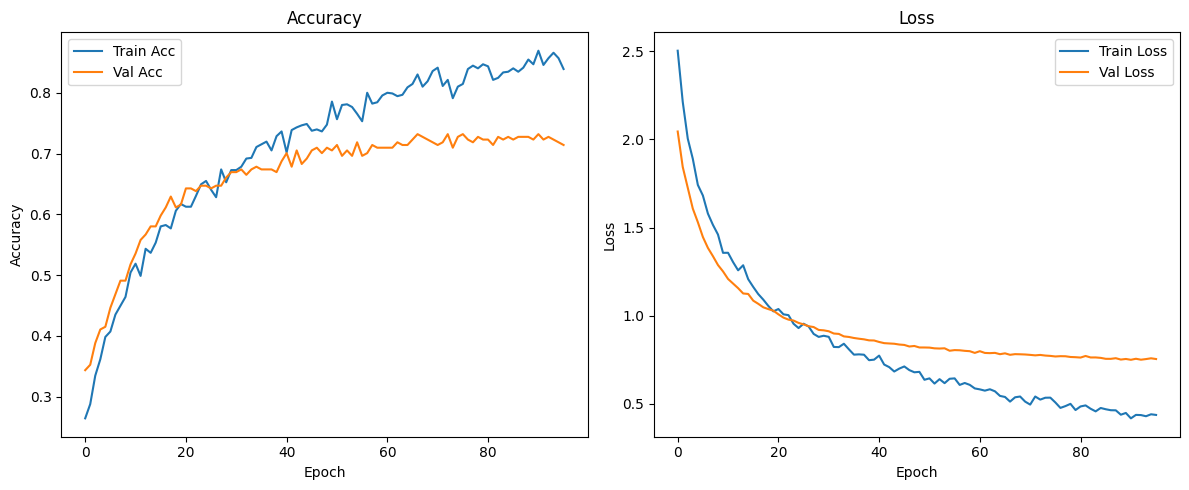

In [ ]:
# === 7. Tracer les courbes loss & accuracy ===
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
from tqdm import tqdm

# === 1. Charger le modèle sauvegardé ===
model = tf.keras.models.load_model(checkpoint_path)

# === 2. Dossier contenant les images de test ===
test_dir = '/content/drive/MyDrive/datatest'
test_filenames = [f for f in os.listdir(test_dir) if f.endswith('.jpg')]

# === 3. Préparer les images de test ===
test_images = []
final_filenames_clean = [f.replace('.jpg', '') for f in final_filenames]

for filename in tqdm(test_filenames):
    img_path = os.path.join(test_dir, filename)
    image = tf.keras.utils.load_img(img_path, target_size=(224, 224))
    image = tf.keras.utils.img_to_array(image)
    image = preprocess_input(image)
    test_images.append(image)
    final_filenames_clean.append(filename)

X_test = np.array(test_images)

# === 4. Prédictions ===
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# === 5. Créer le fichier de soumission Kaggle ===
submission_df = pd.DataFrame({
    "filename": final_filenames_clean,
    "label": y_pred
})

submission_df.to_csv("/content/submission.csv", index=False)
print("✅ Fichier de soumission prêt : /content/submission.csv")


NameError: name 'tf' is not defined